# Image Classification with Instance Segmentation

In [1]:
import os
import random
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.ops as ops

import torchmetrics
from PIL import Image

from torchinfo import summary

import cv2
import shutil
from tqdm.auto import tqdm

from pathlib import Path

torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

## Data Preprocessing

### Custom Dataset Defination

In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        with open(annotation_file, "r") as f:
            self.annotations = json.load(f)["images"]
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_info = self.annotations[idx]
        image_name = image_info["id"]
        image_path = image_info["file_name"]
        image = Image.open(image_path)
        mask_path = os.path.join(self.root_dir, "masks", f'{image_name}.png')

        bboxes = []
        masks = []
        for obj in image_info["objects"]:
            bbox = obj["box"]
            bboxes.append(bbox)
            mask = Image.open(mask_path).convert("L")
            mask = np.array(mask).astype(np.uint8)
            masks.append(mask)

        bboxes = torch.FloatTensor(bboxes)
        masks = np.stack(masks, axis=2)

        target = {}
        target["boxes"] = torch.Tensor(bboxes)
        target["masks"] = transforms.ToTensor()(masks)
        target["labels"] = torch.ones(len(bboxes), dtype=torch.int64)  # Assuming there is only one class in your dataset

        return transforms.ToTensor()(image), target


def collate_fn(batch):
    images = []
    targets = []
    for image, target in batch:
        images.append(image)
        targets.append(target)

    return torch.stack(images, dim=0), targets


# create an instance of the custom dataset
train_dataset = SegmentationDataset(root_dir='set/train', annotation_file='set/train/annotations.json')
test_dataset = SegmentationDataset(root_dir='set/val', annotation_file='set/val/annotations.json')

# create a data loader for the dataset
batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)


In [3]:
# image, targets = next(iter(train_dataloader))

In [4]:
# image = image.to(device)
# targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# image.shape

### Dataset and Dataloader Creation

## Model Creation

In [5]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import unet

model = torchvision.models.detection.maskrcnn_resnet50_fpn().to(device)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.backbone = unet.UNet_with_FCN(num_classes=2, depth=6, start_filts=64).to(device)

### Model checking

In [6]:
# summary(model, input_data=image.to(device), col_names=["input_size", "output_size", "num_params", "params_percent"])

In [7]:
# resnet101 = torchvision.models.resnet50()
# output = model.backbone(image.to(device))
# output["pool"].shape

In [8]:
# output = backbone(image.to(device))
# output["pool"].shape

### Defining Optimiser and Loss Function

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [13]:
def calculate_iou(targets, predictions, batch_size):
    iou = 0
    for i in range(batch_size):
        boxA = targets[i]["boxes"][0]
        keep = ops.nms(predictions[i]["boxes"], predictions[i]["scores"], iou_threshold=0.5)
        boxB = predictions[i]['boxes'][keep][0]
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = torch.max(boxA[0], boxB[0])
        yA = torch.max(boxA[1], boxB[1])
        xB = torch.min(boxA[2], boxB[2])
        yB = torch.min(boxA[3], boxB[3])

        # compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        # compute the area of both the prediction and ground-truth rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou += interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou / batch_size

### Model Training

In [11]:
# with torch.no_grad():
#     model.train()
#     loss_dict = model(images, targets)
# loss_dict

In [14]:
num_epochs = 3

# Training loop
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch [{epoch + 1}/{num_epochs}] :")

    # Training
    model.train()
    train_loss = 0.0
    for i, (images, targets) in enumerate(train_dataloader):
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_loss += losses.item()
        print("\rTrained: ", i + 1, "/ ", len(train_dataloader), end=" ")
    train_loss /= len(train_dataloader)

    # Validation
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for i, (images, targets) in enumerate(test_dataloader):
            images = images.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            model.eval()
            iou = calculate_iou(targets, model(images), batch_size)
            val_iou += iou
            
            print("\rChecked: ", i + 1, "/ ", len(test_dataloader), end="     ")
            
        val_loss /= len(test_dataloader)
        val_iou /= len(test_dataloader)

    # Log training and validation results
    print(f"\rTotal - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val IOU: {val_iou:.4f}", end="\n\n")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/3] :
Total - Train loss: 0.1985 - Val loss: 0.1853 - Val IOU: 0.8281

Epoch [2/3] :
Total - Train loss: 0.1786 - Val loss: 0.1648 - Val IOU: 0.8454

Epoch [3/3] :
Total - Train loss: 0.1647 - Val loss: 0.1584 - Val IOU: 0.8597



## Saving and Loading Model      

In [15]:
# Model Path

MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "Leaf_Detector_MRCNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [16]:
# Saving The Trained Model

torch.save(model, MODEL_SAVE_PATH)

In [6]:
# Loading the Trained Model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.load(MODEL_SAVE_PATH)

## Model Evaluation

In [17]:
eval_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [37]:
images, targets = next(iter(eval_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
images[0].shape

torch.Size([3, 256, 256])

In [38]:
predictions = model(images)

tensor([[ 20.,   4., 248., 247.]], device='cuda:0')


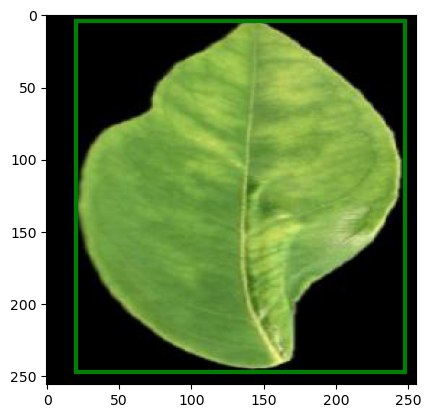

In [39]:
x1, y1, x2, y2 = targets[0]["boxes"][0].detach().cpu()
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
plt.gca().add_patch(Rectangle((x1, y1,),x2 - x1, y2 - y1,
                    edgecolor='green',
                    facecolor='none',
                    lw=3))
print(targets[0]["boxes"])

tensor([ 24.0766,   6.0625, 245.9606, 256.0000], device='cuda:0')


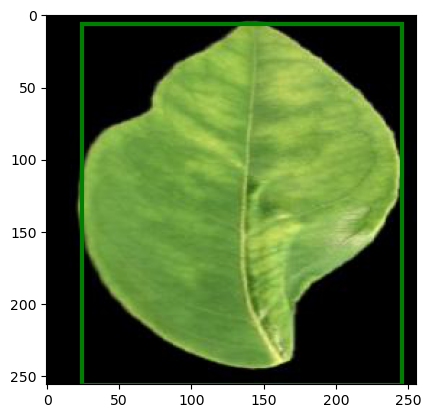

In [40]:
keep = ops.nms(predictions[0]["boxes"], predictions[0]["scores"], iou_threshold=0.7)
x1, y1, x2, y2 = predictions[0]["boxes"][keep][0].detach().cpu()
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
plt.gca().add_patch(Rectangle((x1, y1,),x2 - x1, y2 - y1,
                    edgecolor='green',
                    facecolor='none',
                    lw=3))
print(predictions[0]["boxes"][:][0].detach())

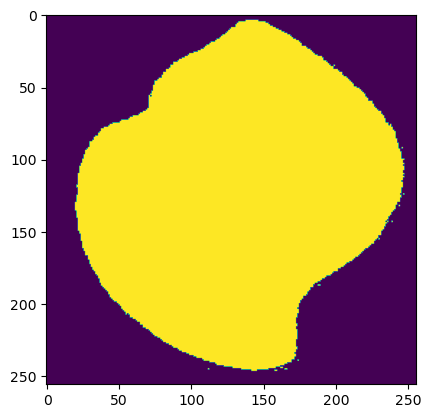

In [41]:
mask = targets[0]["masks"]
mask.shape
plt.imshow(mask.squeeze().cpu().numpy())

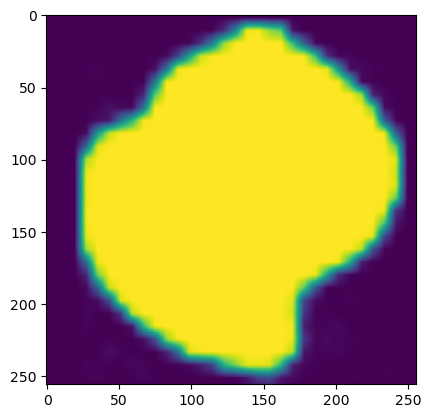

In [42]:
pred_mask = predictions[0]["masks"][keep][0].detach().cpu()

plt.imshow(pred_mask.squeeze().cpu().numpy())

In [49]:
image = Image.open("Multileaf Checker.jpg")
image_tensor = transforms.ToTensor()(image)
image_tensor = image_tensor.unsqueeze(dim=0).to(device)

In [50]:
predictions = model(image_tensor)

In [51]:
keep = ops.nms(predictions[0]["boxes"], predictions[0]["scores"], iou_threshold=0.7)
keep

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       device='cuda:0')

In [54]:
i = 0

[521.2186 351.4117 741.5443 533.    ]


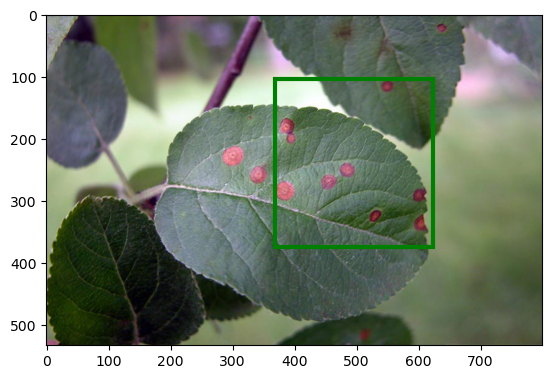

In [69]:
boxes = predictions[0]["boxes"][keep].detach().cpu().numpy()
# for box in boxes:
#     x1, y1, x2, y2 = box
#     plt.gca().add_patch(Rectangle((x1, y1,),x2 - x1, y2 - y1,
#                         edgecolor='green',
#                         facecolor='none',
#                         lw=3))
#     print(box)

x1, y1, x2, y2 = boxes[i]
plt.gca().add_patch(Rectangle((x1, y1,),x2 - x1, y2 - y1,
                    edgecolor='green',
                    facecolor='none',
                    lw=3))
print(box)
i += 1

plt.imshow(image_tensor.permute(0, 2, 3, 1).squeeze().cpu().numpy())

In [55]:
masks = predictions[0]["masks"][keep].detach().cpu().numpy()

In [70]:
i = 0

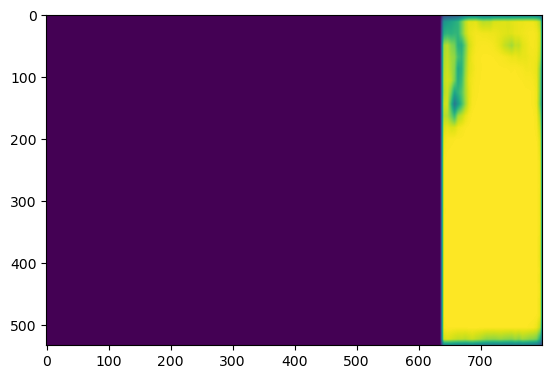

In [82]:
mask = masks[i]
i += 1
plt.imshow(mask.squeeze())